In [1]:
! pip install hazm
! pip install arabic_reshaper
! pip install keras --upgrade
! pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 80.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which i

In [2]:
import random
import warnings
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from string import punctuation
from hazm import Normalizer, Lemmatizer, Stemmer, stopwords_list, word_tokenize
from progressbar import ProgressBar
from bidi.algorithm import get_display
import arabic_reshaper
warnings.filterwarnings('ignore')

In [3]:
font_file = '/kaggle/input/arial-font/arial.ttf'
dataset_path = '/kaggle/input/persion-news-dataset/per.csv'
df = pd.read_csv(dataset_path)
df.drop(['NewsID', 'Date', 'Time', 'Category'], axis=1, inplace=True)
df.head()

,Title,Body,Category2
0,\nوزير علوم درجمع استادان نمونه: سن بازنشستگي ...,\nوزير علوم در جمع استادان نمونه كشور گفت: از ...,\nآموزشي
1,\nگردهمايي دانش‌آموختگان موسسه آموزش عالي سوره...,\nبه گزارش سرويس صنفي آموزشي خبرگزاري دانشجويا...,\nآموزشي
2,\nنتايج آزمون دوره‌هاي فراگير دانشگاه پيام‌نور...,\nنتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و...,\nآموزشي
3,\nهمايش يكروزه آسيب شناسي مفهوم روابط عمومي در...,\n,\nاجتماعي
4,\nوضعيت اقتصادي و ميزان تحصيلات والدين از مهمت...,\nمحمدتقي علوي يزدي، مجري اين طرح پژوهشي در اي...,\nآموزشي


In [4]:
normalizer = Normalizer()
stop_words_lsit = stopwords_list()
punctuation_lsit = list(punctuation)
punctuation_lsit.extend(['»', '«', '؛' ,'،' ,'؟'])
stemmer = Stemmer()
lemmetizer = Lemmatizer()

In [5]:
p = ProgressBar(max_value=len(df)).start()
dataset = pd.DataFrame(columns=['Text', 'Label'])
for i, row in df.iterrows():
    text = row['Title'] + ' ' + row['Body']
    text_normal = normalizer.normalize(text)
    text_normal_tokenized = word_tokenize(text_normal)
    text_normal_tokenized_filtered = [w for w in text_normal_tokenized if w not in stop_words_lsit and w not in punctuation_lsit]
    text_normal_tokenized_filtered_stem = [stemmer.stem(w) for w in text_normal_tokenized_filtered]
    text_normal_tokenized_filtered_lem = [lemmetizer.lemmatize(w).replace('#', ' ') for w in text_normal_tokenized_filtered]
    dataset.loc[i]={
        'Text':' '.join(text_normal_tokenized_filtered_stem) + ' ' + ' '.join(text_normal_tokenized_filtered_lem),
        'Label':row['Category2'].replace('\n', '').strip(),
    }
    p.update(i + 1)
p.finish()

100% (10999 of 10999) |##################| Elapsed Time: 0:01:33 Time:  0:01:330007


In [6]:
category_counts = dataset['Label'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

category_counts = category_counts.sort_values(by='Count', ascending=True)

fig = px.bar(
    category_counts,
    x='Count',
    y='Category',
    orientation='h',
    title='Distribution of News Categories',
    labels={'Count': 'Number of News'},
    color='Count',
    color_continuous_scale='viridis',
)

fig.update_layout(
    template='plotly_dark',
    xaxis_title='Count',
    yaxis_title='Category',
    coloraxis_colorbar=dict(title='Count'),
)

fig.update_yaxes(categoryorder='total ascending', tickmode='linear', tick0=0, dtick=1)

fig.update_layout(height=800, margin=dict(l=150, r=20, t=50, b=50))

fig.show()

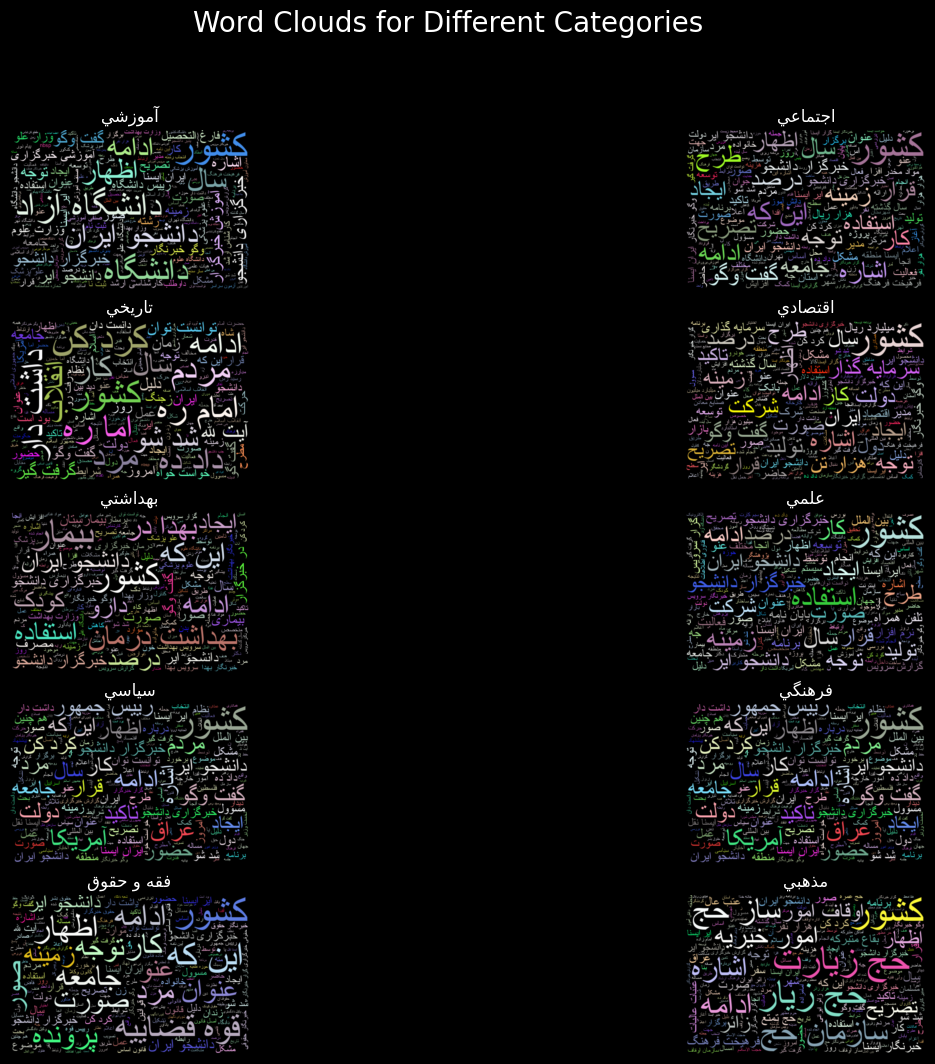

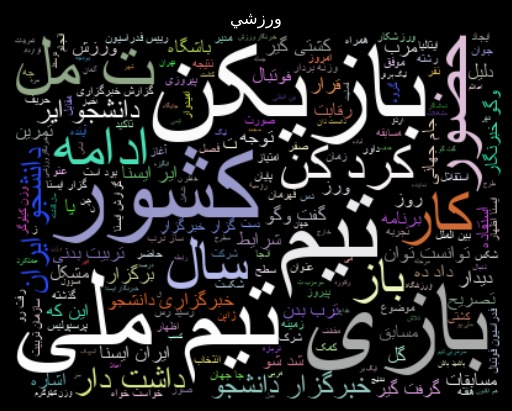

In [7]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * random.random())
    s = int(100.0 * random.random())
    l = int(50.0 * random.random()) + 50
    return 'hsl({}, {}%, {}%)'.format(h, s, l)


plt.style.use('dark_background')

etc = None
fig, axes = plt.subplots(5, 2, figsize=(16, 12), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
for ax, category in zip(axes.flatten(), dataset['Label'].unique()):
    try:
        wordcloud = WordCloud(font_path=font_file, width=600, height=400, random_state=42, max_font_size=100, background_color='black',
                          color_func=random_color_func,).generate(' '.join(arabic_reshaper.reshape(t) for t in dataset[dataset['Label']==category]['Text']))
    except:
        etc = category
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(get_display(arabic_reshaper.reshape(category)), color='white')
plt.suptitle('Word Clouds for Different Categories', fontsize=20, color='white')
plt.show()
wordcloud = WordCloud(font_path=font_file, width=400, height=300, random_state=42, max_font_size=100, background_color='black',
                          color_func=random_color_func,).generate(' '.join(arabic_reshaper.reshape(t) for t in dataset[dataset['Label']=='ورزشي']['Text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(get_display(arabic_reshaper.reshape('ورزشي')), color='white')
plt.axis('off')
plt.show();